## Import 

In [1]:
# Neural Network
from tensorflow.keras.applications import imagenet_utils
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model
import keras
import tensorflow as tf

# For measuring the inference time.
import time
import random

# Computer Vision
import cv2

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Math
import numpy as np

# File handling
import pickle
from os import listdir
from os.path import isfile, join
import os

Using TensorFlow backend.


## Loading Images

In [2]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [3]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "Data-Images",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=2591,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 2452 images belonging to 4 classes.


In [4]:
# Image classes
image_gen.class_indices

{'.ipynb_checkpoints': 0, 'Assault Rifle': 1, 'Handgun': 2, 'No Firearm': 3}

In [5]:
# Image shape
image_gen.image_shape

(300, 300, 3)

## Separating To Images and Labels

In [6]:
images, labels = next(image_gen)

In [7]:
images.shape

(2452, 300, 300, 3)

In [8]:
labels.shape

(2452, 4)

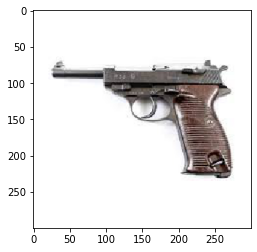

In [9]:
plt.imshow(images[23])

In [10]:
def display_image(image_num):
    """
    Prints out picture of
    the image that is selected
    
    After the else statement,
    we try to use the file name
    in oder to print out the image,
    
    while the first image is used to 
    print the image directly without a 
    filename.
    """
    try:
        fig = plt.figure(figsize=(20, 15))
        plt.grid(False)
        plt.imshow(images[image_num])
    except (RuntimeError, TypeError, NameError):
        print("[INFO] Could not print image")
        print("[INFO] trying something else...")
    else:
        print("[INFO] returning image...")
        # Image path - getting images on file
        image_paths = "Demo-Images/"
        image_select = image_paths + ([f for f in listdir(image_paths) if isfile(join(image_paths, f))][image_num])  # Other way instead of the listdir function
        img = plt.imread(fname=image_select)
        plt.imshow(img)

[INFO] returning image...


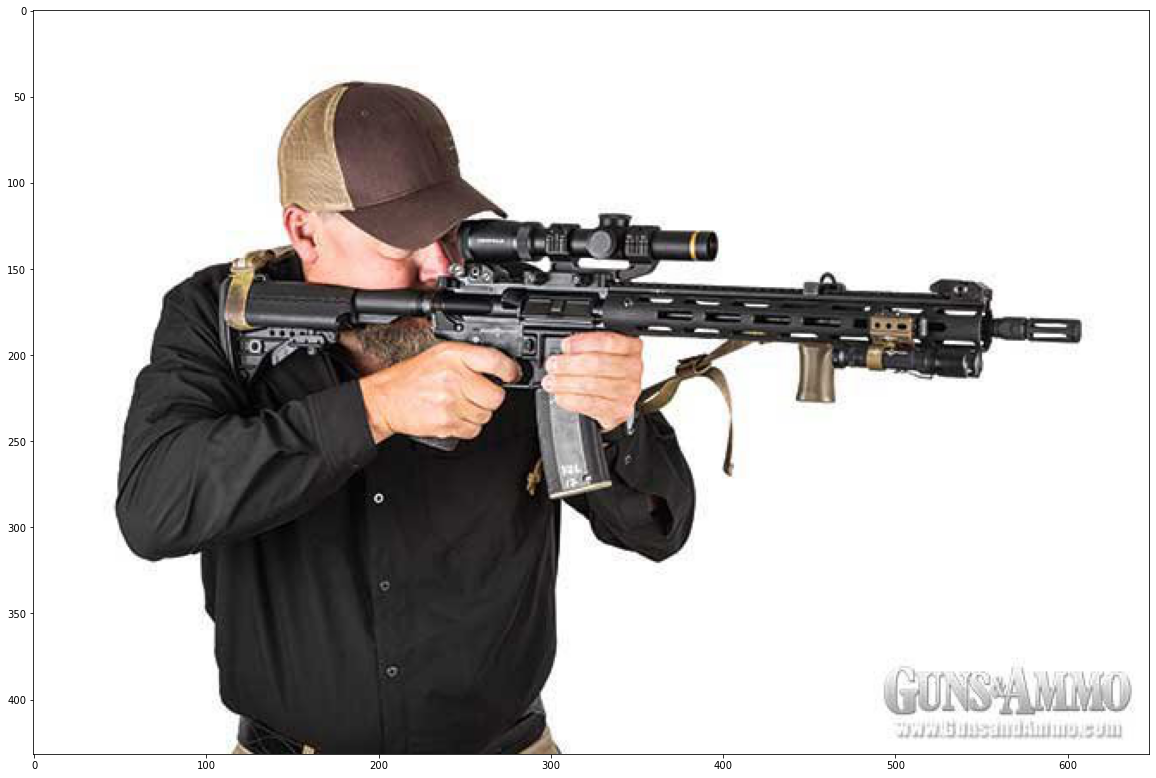

In [11]:
display_image(image_num=32)

# Loading Model and Prediction

In [12]:
image_gen.filepaths[0]

'Data-Images/Assault Rifle/0008dce40e.jpg'

In [16]:
def listdirimage(path):
    """
    Checking for file path
    of images
    """
    lst = []
    if os.path.isdir(path): # Check this path = path to folder
        for file in os.listdir(path):  
            file_path = os.path.join(path, file)  
            lst.append(file_path)
    return lst

In [14]:
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)

# Image Classes
classes = ['Assault Rifle', 'Handgun', 'No Firearm']

# Prediction Function
def predict(model, image_num):
    # Image path - getting images on file
    image_paths = "Demo-Images/"
    image_select = image_paths + ([f for f in listdir(image_paths) if isfile(join(image_paths, f))])[image_num] # Other way instead of the listdir function
    
    img = load_img(image_select, target_size=(300, 300))  # Loading image
    img = img_to_array(img)  # Transforming image to array
    img = img / 255  # Normalizing Image
    img = np.expand_dims(img, axis=0)  # Expanding dimensions
    predict = cnn_model.predict(img)  # Predicting the image
    pred_name = classes[np.argmax(predict)]  # Predicting the name
    prediction = str(round(predict.max() * 100, 3))
    print(display_image(image_num=image_num))
    return prediction + '%', pred_name

In [15]:
predict(cnn_model, image_num=232)

IndexError: list index out of range

# IoU (Intersection Over Union)

In [33]:
def compute_iou(boxA, boxB):
    """
    IOU is a form of 
    performance measurement
    for our object detector.
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

# Non-Maximum Suppression

In [34]:
#  Felzenszwalb et al.
def example_non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

In [35]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

# Selective Search

In [36]:
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)

# Image Classes
classes = ['Assault Rifle', 'Handgun', 'No Firearm']

# Prediction Function
def predict_region_of_proposals(model, proposals_used):
    """
    predicts regions of proposals
    """
    predict = model.predict(proposals_used)  # Predicting the image
    for proposals in predict:
        pred_name = classes[np.argmax(proposals)]  # Predicting the name
    prediction = str(round(predict.max() * 100, 3))
    print(pred_name)
    return predict

In [37]:
# Setting a max amount of region proposals used when running selective search
max_proposals = 2_000
max_proposals_infer = 100  # Search for (1) gathering training data and (2) performing inference

In [38]:
# Define the maximum number of positive and negative images to be
# Denerated from each image
max_positive = 30
max_negative = 10

In [39]:
# initialize the input dimensions to the network
input_dimensions = (300, 300)  # 300 by 300 because that's what the CNN Model was tested on
# define the path to the output model
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)  # Loading CNN model from keras

# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
min_probability = 0.80

In [40]:
# initialize OpenCV's selective search implementation and set the
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [41]:
# Input image in selective search

# Image path - getting images on file
image_num = 2
image_paths = "Demo-Images/"
image_select = image_paths + ([f for f in listdir(image_paths) if isfile(join(image_paths, f))][image_num])  # Other way instead of the listdir function
    

# load the input image (224x224) and preprocess it
image = load_img(image_select, target_size=input_dimensions)
image = img_to_array(image)

# Setting base image that will be used
ss.setBaseImage(image)

# Choosing which selective search
ss.switchToSelectiveSearchQuality()

IndexError: list index out of range

In [ ]:
display_image(image_num)

In [ ]:
# run selective search on the input image
start = time.time()
rects = ss.process()  # Run Selective Search
end = time.time()

# show how along selective search took to run along with the total
# number of returned region proposals
print(f"[INFO] selective search took {np.round(end - start, decimals=3)} seconds")
print(f"[INFO] {len(rects)} total region proposals")

In [16]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:max_proposals_infer]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, input_dimensions,
        interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))

NameError: name 'rects' is not defined

In [527]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float64")
boxes = np.array(boxes, dtype="int64")
print(f"[INFO] proposal shape: {proposals.shape}")

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = predict_region_of_proposals(model=cnn_model, proposals_used=proposals)  # Predicting the proposals for our desired object
                                      # Result: 100 proposals 300 by 300 image with RGB color
# Probabilty of each proposal (Region of Proposals)
print(f"[INFO] Probabiltiy Scores: {proba}")

[INFO] proposal shape: (100, 300, 300, 3)
[INFO] classifying proposals...
Assault Rifle
[INFO] Probabiltiy Scores: [[2.19422579e-02 9.24041033e-01 5.40166572e-02]
 [7.71602616e-02 9.20301795e-01 2.53791106e-03]
 [1.25691652e-01 8.74299407e-01 8.91636410e-06]
 [4.17016923e-01 5.70261836e-01 1.27211604e-02]
 [1.92282777e-02 9.80514348e-01 2.57409847e-04]
 [7.32173741e-01 2.66916186e-01 9.10075381e-04]
 [9.90549147e-01 9.43615846e-03 1.47885630e-05]
 [7.08129182e-02 9.29176509e-01 1.05856871e-05]
 [1.36885971e-01 8.49052370e-01 1.40616791e-02]
 [4.56186354e-01 5.43745399e-01 6.83090038e-05]
 [1.26720508e-04 9.91120279e-01 8.75305850e-03]
 [1.33514851e-01 8.41911674e-01 2.45735478e-02]
 [3.34137827e-02 1.54628068e-01 8.11958134e-01]
 [3.14684063e-02 9.67350125e-01 1.18144986e-03]
 [9.88268495e-01 1.16525916e-02 7.89211190e-05]
 [8.92298222e-01 1.23162502e-02 9.53854993e-02]
 [7.35198287e-03 8.42631876e-01 1.50016174e-01]
 [8.67898539e-02 8.92366469e-01 2.08437033e-02]
 [5.05985439e-01 4.93

In [528]:
boxes

array([[173, 281, 224, 300],
       [  0, 199,  25, 213],
       [263, 193, 300, 224],
       [ 71, 158,  92, 178],
       [ 64, 223, 108, 293],
       [263, 151, 300, 161],
       [ 91, 105, 213, 232],
       [158, 109, 300, 176],
       [167, 180, 195, 188],
       [  0, 177,  21, 195],
       [ 91, 180, 300, 300],
       [167, 180, 222, 220],
       [193, 222, 212, 234],
       [104, 147, 213, 192],
       [ 75,   0, 300, 148],
       [ 59,   0,  80,  22],
       [  0, 193,  40, 233],
       [171, 210, 300, 300],
       [192, 105, 209, 123],
       [225, 167, 257, 185],
       [  0, 227,  15, 241],
       [193, 193, 260, 214],
       [ 89,   0, 104,  16],
       [213, 116, 273, 123],
       [  0, 234,  21, 298],
       [ 45, 177,  71, 234],
       [  0, 184,  40, 213],
       [ 89,  52, 117,  64],
       [232, 141, 300, 161],
       [235,  89, 252, 115],
       [ 21, 221,  89, 268],
       [199,  96, 241, 103],
       [107,  78, 130, 103],
       [  0, 184,  39, 201],
       [ 88,  

# Filtering Predictions

In [529]:
# # find the index of all predictions that are positive for the
# # "Assault Rifle" class
# print("[INFO] applying NMS...")
# labels = lb.classes_[np.argmax(proba, axis=1)]
# idxs = np.where(labels == 0)[0] # Assault Rifle
# # use the indexes to extract all bounding boxes and associated class
# # label probabilities associated with the "Assault Rifle" class
# boxes = boxes[idxs]
# proba = proba[idxs][:, 1]
# # further filter indexes by enforcing a minimum prediction
# # probability be met
# idxs = np.where(proba >= min_probability)
# boxes = boxes[idxs]
# proba = proba[idxs]







# find the index of all predictions that are greater
# than the minimum probability
print("[INFO] applying NMS...")
idxs = np.where(proba >= min_probability)[0]

# further filter indexes by enforcing a minimum prediction
# probability be met
boxes = boxes[idxs]
proba = proba[idxs]

[INFO] applying NMS...


# View Results

In [70]:
# loop over the region proposals in chunks (so we can better
# visualize them)
# for i in range(0, len(rects), 100):
#     # clone the original image so we can draw on it
#     output = image.copy()
#     # loop over the current subset of region proposals
#     for (x, y, w, h) in rects[i:i + 100]:
#         # draw the region proposal bounding box on the image
#         color = [random.randint(0, 255) for j in range(0, 3)]
#         cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
#     # show the output image
#     cv2.imshow("Output", output)
#     key = cv2.waitKey(0) & 0xFF
#     # if the `q` key was pressed, break from the loop
#     if key == ord("q"):
#         break

In [ ]:
# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = f"{np.round(prob * 100, decimals=3)}%"
    cv2.putText(clone, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after *before* running NMS
cv2.imshow("Before NMS", clone)
cv2.waitKey(0)

In [ ]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)
# loop over the bounding box indexes
for i in boxIdxs:
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = boxes[i]
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = f"{np.round(proba[i] * 100, decimals=3)}%"
    cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2.imshow("After NMS", image)
cv2.waitKey(0)